# Predict survival on the Titanic
This is a simple example and starting point for neural networks with TensorFlow.
We create a feed-forward neural network with two hidden layers (128 and 256 nodes)
and ReLU units.
The test accuracy is around 78.5 % - which is not too bad for such a simple model.  
Credits: https://www.kaggle.com/hbaderts/simple-feed-forward-neural-network-with-tensorflow/data

In [2]:
import numpy as np
import pandas as pd        # For loading and processing the dataset
import tensorflow as tf    # Of course, we need TensorFlow.
from sklearn.model_selection import train_test_split

## Reading and cleaning the input data

We first read the CSV input file using Pandas.
Next, we remove irrelevant entries, and prepare the data for our neural network.
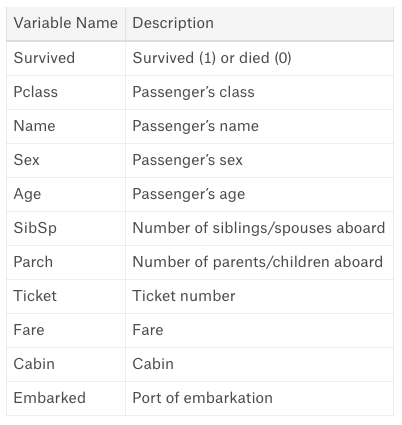

In [3]:
# Read the CSV input file and show first 5 rows
df_train = pd.read_csv('dataset/titanic_dataset/train.csv')
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# We can't do anything with the Name, Ticket number, and Cabin, so we drop them.
df_train = df_train.drop(['PassengerId','Name','Ticket', 'Cabin'], axis=1)

In [5]:
# To make 'Sex' numeric, we replace 'female' by 0 and 'male' by 1
df_train['Sex'] = df_train['Sex'].map({'female':0, 'male':1}).astype(int) 

In [6]:
# We replace 'Embarked' by three dummy variables 'Embarked_S', 'Embarked_C', and 'Embarked Q',
# which are 1 if the person embarked there, and 0 otherwise.
df_train = pd.concat([df_train, pd.get_dummies(df_train['Embarked'], prefix='Embarked')], axis=1)
df_train = df_train.drop('Embarked', axis=1)

In [7]:
# We normalize the age and the fare by subtracting their mean and dividing by the standard deviation
age_mean = df_train['Age'].mean()
age_std = df_train['Age'].std()
df_train['Age'] = (df_train['Age'] - age_mean) / age_std

fare_mean = df_train['Fare'].mean()
fare_std = df_train['Fare'].std()
df_train['Fare'] = (df_train['Fare'] - fare_mean) / fare_std

In [8]:
# In many cases, the 'Age' is missing - which can cause problems. Let's look how bad it is:
print("Number of missing 'Age' values: {:d}".format(df_train['Age'].isnull().sum()))

# A simple method to handle these missing values is to replace them by the mean age.
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].mean())

Number of missing 'Age' values: 177


In [9]:
# With that, we're almost ready for training
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,-0.530005,1,0,-0.502163,0,0,1
1,1,1,0,0.571430,1,0,0.786404,1,0,0
2,1,3,0,-0.254646,0,0,-0.488580,0,0,1
3,1,1,0,0.364911,1,0,0.420494,0,0,1
4,0,3,1,0.364911,0,0,-0.486064,0,0,1


In [10]:
# Finally, we convert the Pandas dataframe to a NumPy array, and split it into a training and test set
X_train = df_train.drop('Survived', axis=1).as_matrix()
y_train = df_train['Survived'].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

/Users/trungtv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/trungtv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
# We'll build a classifier with two classes: "survived" and "didn't survive",
# so we create the according labels
# This is taken from https://www.kaggle.com/klepacz/titanic/tensor-flow
labels_train = (np.arange(2) == y_train[:,None]).astype(np.float32)
labels_test = (np.arange(2) == y_test[:,None]).astype(np.float32)
labels_train

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

## Define TensorFlow model
In a first step, we define how our neural network will look.
We create a network with 2 hidden layers with ReLU activations, and an output layer with softmax.
We use dropout for regularization. 

In [12]:
inputs = tf.placeholder(tf.float32, shape=(None, X_train.shape[1]), name='inputs')
label = tf.placeholder(tf.float32, shape=(None, 2), name='labels')

# First layer
hid1_size = 128
# Weight for the first layer
w1 = tf.Variable(tf.random_normal([hid1_size, X_train.shape[1]]))
# Bias
b1 = tf.Variable(tf.constant(0.1, shape=(hid1_size, 1)))
# Ouput = sigmoid(w1 * inputs + b)                 
y1 = tf.nn.sigmoid(tf.add(tf.matmul(w1, tf.transpose(inputs)), b1))                 
# Second layer
hid2_size = 256
w2 = tf.Variable(tf.random_normal([hid2_size, hid1_size]))
b2 = tf.Variable(tf.constant(0.1, shape=(hid2_size, 1)))                
y2 = tf.nn.sigmoid(tf.add(tf.matmul(w2, y1), b2))
# Output layer
wo = tf.Variable(tf.random_normal([2, hid2_size]))
bo = tf.Variable(tf.random_normal([2,1]))
yo = tf.transpose(tf.add(tf.matmul(wo, y2), bo))                 

In [13]:
# X_train.shape[1] == Number of features == 9
X_train.shape[1]

9

The output is a softmax output, and we train it with the cross entropy loss.
We further define functions which calculate the predicted label, and the accuracy of the network.

In [14]:
# Loss function and optimizer
learning_rate = tf.placeholder(tf.float32, shape=())
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=yo, labels=label))
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
# Prediction
pred = tf.nn.softmax(yo)
pred_label = tf.argmax(pred, 1)
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



## Train the network!

Finally, we are ready to train our network. Let's initialize TensorFlow and start training.

In [15]:
# Create operation which will initialize all variables
init =tf.global_variables_initializer()
# Configure GPU not to use all memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Start a new tensorflow session and initialize variables
sess = tf.InteractiveSession(config=config)
sess.run(init)

In [17]:
# This is the main training loop: we train for 50 epochs with a learning rate of 0.05 and another 
# 50 epochs with a smaller learning rate of 0.01
for learning_rate_1 in [0.05, 0.01]:
    for epoch in range(50):
        avg_cost = 0.0

        # For each epoch, we go through all the samples we have.
        for i in range(X_train.shape[0]):
            # Finally, this is where the magic happens: run our optimizer, feed the current example into X and the current target into Y
            _,c = sess.run([optimizer,loss], feed_dict={learning_rate:learning_rate_1, inputs:X_train[i, None], label: labels_train[i, None]})
            avg_cost += c
        avg_cost /= X_train.shape[0]    

        # Print the cost in this epcho to the console.
        if epoch % 10 == 0:
            print("Epoch: {:3d}    Train Cost: {:.4f}".format(epoch, avg_cost))

Epoch:   0    Train Cost: 2.2131
Epoch:  10    Train Cost: 0.9155
Epoch:  20    Train Cost: 0.7749
Epoch:  30    Train Cost: 0.6790
Epoch:  40    Train Cost: 0.6194
Epoch:   0    Train Cost: 0.4143
Epoch:  10    Train Cost: 0.3111
Epoch:  20    Train Cost: 0.3012
Epoch:  30    Train Cost: 0.2946
Epoch:  40    Train Cost: 0.2895


We calculate the accuracy on our training set, and (more importantly) our test set.

In [ ]:
acc_train = accuracy.eval(feed_dict={inputs: X_train, label: labels_train})
print("Train accuracy: {:3.2f}%".format(acc_train*100.0))

acc_test = accuracy.eval(feed_dict={inputs: X_test, label: labels_test})
print("Test accuracy:  {:3.2f}%".format(acc_test*100.0))

## Predict new passengers

If we're happy with these results, we load the test dataset, and do all pre-processing steps we also did for the training set.

In [18]:
df_test = pd.read_csv('dataset/titanic_dataset/test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [19]:
# Do all pre-processing steps as above
df_test = df_test.drop(['Name', 'Ticket', 'Cabin'], axis=1)
df_test['Sex'] = df_test['Sex'].map({'female':0, 'male':1}).astype(int)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Embarked'], prefix='Embarked')], axis=1)
df_test = df_test.drop('Embarked', axis=1)
df_test['Age'] = (df_test['Age'] - age_mean) / age_std
df_test['Fare'] = (df_test['Fare'] - fare_mean) / fare_std
df_test.head()
X_test = df_test.drop('PassengerId', axis=1).as_matrix()

/Users/trungtv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


Then we predict the label of all our test data

In [20]:
# Predict
for i in range(X_test.shape[0]):
    df_test.loc[i, 'Survived'] = sess.run(pred_label, feed_dict={inputs: X_test[i, None]}).squeeze()
df_test

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Survived
0,892,3,1,0.330491,0,0,-0.490508,0,1,0,0.0
1,893,3,0,1.190988,1,0,-0.507194,0,0,1,0.0
2,894,2,1,2.223584,0,0,-0.453112,0,1,0,0.0
3,895,3,1,-0.185807,0,0,-0.473739,0,0,1,0.0
4,896,3,0,-0.530005,1,1,-0.400792,0,0,1,0.0
5,897,3,1,-1.080723,0,0,-0.462419,0,0,1,0.0
6,898,3,0,0.020713,0,0,-0.494532,0,1,0,1.0
7,899,2,1,-0.254646,1,1,-0.064480,0,0,1,0.0
8,900,3,0,-0.805364,0,0,-0.502582,1,0,0,1.0
9,901,3,1,-0.598845,2,0,-0.162078,0,0,1,0.0


In [21]:
# Important: close the TensorFlow session, now that we're finished.
sess.close()

## Can you do mini batch training?